In [1]:
#ViT
import numpy as np
import pandas as pd
from memory_profiler import memory_usage

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split
#from transformers import ViTFeatureExtractor, ViTForImageClassification

import random
from PIL import Image, ImageOps
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
plt.style.use('dark_background')

#If using script on terminal
#from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
num_workers = 0
script = False

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

model = timm.create_model("vit_base_patch16_224", pretrained=True)
path = 'jx_vit_base_p16_224-80ecf9dd.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images,  train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data,train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if (pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


In [6]:
model = ViTBase16(n_classes=9, pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

name = 'Experiments/exp_56/model.pt'#'model.pt'#'other.pt' 
model = torch.load(name, map_location=torch.device('cpu'))

In [7]:
# Real lenses
path_cutouts = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/real_lenses/Jack_Y6/Cutouts/'
hdu_list = fits.open(path_cutouts + 'Jack_Y6.fits')
lenses = hdu_list[1].data.astype(np.float32)
data_pos = hdu_list[2].data
data_pos = Table(data_pos)
data_pos = data_pos.to_pandas()
#data_pos = data_pos.drop(['TILENAME', 'Candidate'], axis=1)
columns_data = data_pos.columns
hdu_list.close()

dataset = ImageDataset(lenses, data_pos, np.zeros(len(lenses), dtype = np.int64), transform=transform)
print(len(dataset))

246


In [8]:
def search(dataset):
    prob_list = []
    search_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, num_workers=num_workers, shuffle=True)
    images = len(categories)*[np.zeros((1,3,45,45))]
    all_data = len(categories)*[pd.DataFrame()]
    
    for i_batch, sample in enumerate(tqdm(search_loader)):
        #if(i_batch==20): break
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
        
        output = model(sample_image)
    
        prob = nn.Softmax(dim=1)(output)
        prob_list.append(prob[:,0].detach().cpu().numpy()[0])
        i = prob.argmax(dim=1)
        
        new_df = pd.DataFrame(sample_data, columns=columns_data)
        new_df['Prob'] = prob[:,i].detach()
        all_data[i] = all_data[i].append(new_df, ignore_index=True)
        images[i] = np.append(images[i], np.array(sample_img), axis = 0)
    
    for i in range(len(categories)):
        images[i] = np.delete(images[i], 0, axis = 0)
    
    return(images, all_data, prob_list)

In [9]:
categories = ['Positives', 'Rings', 'Smooth', 'Companion', 'SDSS', 'DES_spirals', 'Crowded', 'Errors', 'Most_negatives']
images, all_data, prob_list = search(dataset)

right_data = all_data[0]
wrong_data = pd.DataFrame(columns=columns_data)

for i in range(len(all_data)):
    if(i == 0): continue
    wrong_data = wrong_data.append(all_data[i])

  0%|          | 0/246 [00:00<?, ?it/s]

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [10]:
#Default threshold of probability
print('Total: ' + str(len(lenses)))
print('Detected: {}, not detected: {} \n'.format(len(right_data), len(wrong_data)))

print('Not identified lenses with Einstein radius > 6: ' + str(len(wrong_data[wrong_data['einstein_radius'] > 6])))
print('Identified lenses with Einstein radius < 6: ' + str(len(right_data[right_data['einstein_radius'] <= 6])))
print(' ')

for i in range(len(images)):
    if(len(images[i])==0): continue
    num = len(all_data[i][all_data[i]['einstein_radius'] <= 6 ])
    line = 'Labeled as {}: {}'.format(categories[i], len(images[i]))
    print(line, '| ' + str(num))

    
print(' ')
ind = right_data[right_data['Prob'] > 0.75].index
print('Detected with a 0.75 threshold: '+ str(len(ind)))
ind = right_data[right_data['Prob'] > 0.8].index
print('Detected with a 0.8 threshold: '+ str(len(ind)))

Total: 246
Detected: 99, not detected: 147 

Not identified lenses with Einstein radius > 6: 111
Identified lenses with Einstein radius < 6: 91
 
Labeled as Positives: 99 | 91
Labeled as Rings: 3 | 2
Labeled as Smooth: 2 | 2
Labeled as Companion: 5 | 5
Labeled as SDSS: 2 | 2
Labeled as DES_spirals: 1 | 0
Labeled as Crowded: 8 | 6
Labeled as Most_negatives: 126 | 19
 
Detected with a 0.75 threshold: 87
Detected with a 0.8 threshold: 86


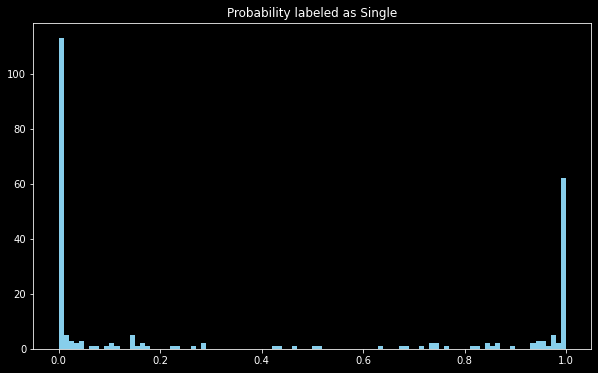

In [11]:
plt.figure(figsize=(10,6))
plt.title('Probability labeled as Single')
plt.hist(prob_list, 100, color = "skyblue")
plt.show()

In [12]:
def write_fit_file(name, x, data):
    my_types = {'COADD_OBJECT_ID': int, 'TILENAME': str, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': float, 'IMAFLAGS_ISO_R': float, 'IMAFLAGS_ISO_I': float,
       'IMAFLAGS_ISO_Z': float, 'rank': int, 'num_sources': int, 'num_lenses': int, 'mem_match_id': int,
       'einstein_radius': float, 'einstein_radius_err': float, 'ACT': int, 'BBNA': int, 'BNA': int, 'TI': int,
       'RNA': int, 'RNA2': int, 'redM': float, 'redM_missed': float, 'SPTPol': float, 'Prob': float}
    data = data.astype(my_types)
    
    primary = fits.PrimaryHDU()
    image = fits.ImageHDU(x, name="IMAGE")
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image, table])
    hdu_list.writeto(name + '.fits', overwrite=True)   
    hdu_list.close()

In [13]:
def make_plot_all(objects, data):
    
    for i in range(len(objects)):
        if(i%4 == 0):
            plt.figure(figsize=(12,8))
            for j in range(4):
                if(i+j > len(objects)-1): break
                plt.subplot(1,4,j+1)
                title = '{:.3f}'.format(data['Prob'].values[i+j])
                print(data['COADD_OBJECT_ID'].values[i+j])
                plt.title(title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.show()

Not identified with E < 6 

Rings
1297969687
1293454009


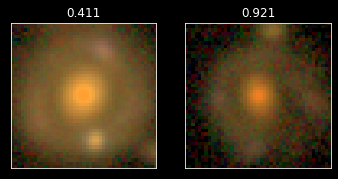

 
Smooth
1098080005
1511180764


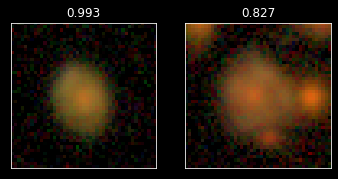

 
Companion
1354965854
1515924344
1096272141
1099199002


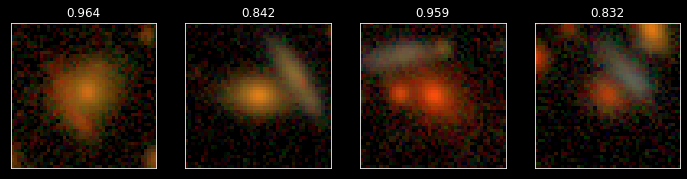

1059844041


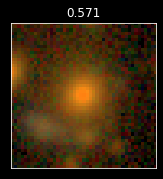

 
SDSS
1544871292
1095104928


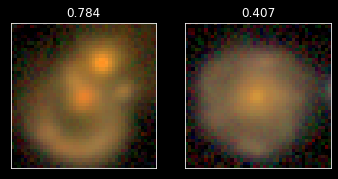

 
DES_spirals
 
Crowded
1555731785
1090875242
931716591
1237872703


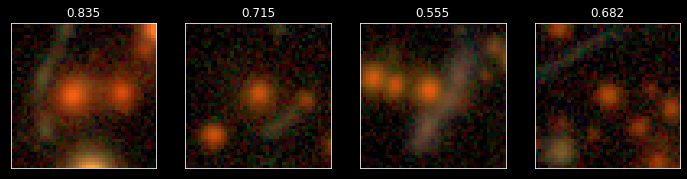

940222725
1412479687


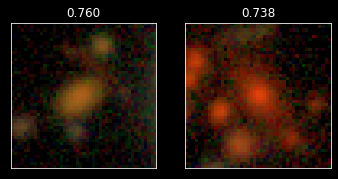

 
Errors
 
Most_negatives
967663413
1556812908
1230216549
1307294028


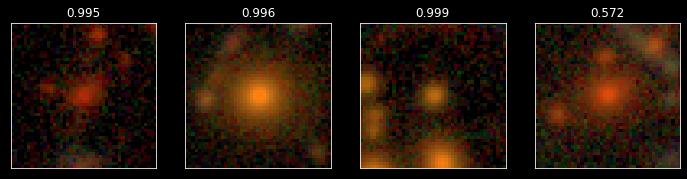

1473678153
1408480079
1176577162
1346316177


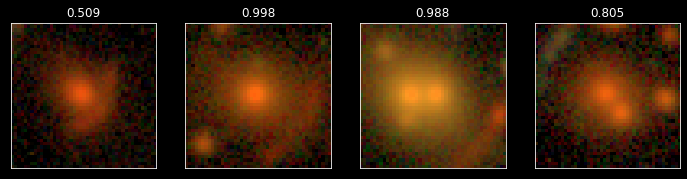

1616237624
1238888461
891448380
1132128416


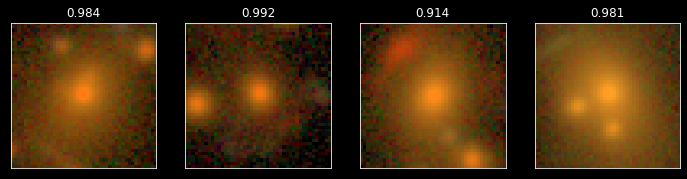

1603413407
1539117960
1193389759
1032611021


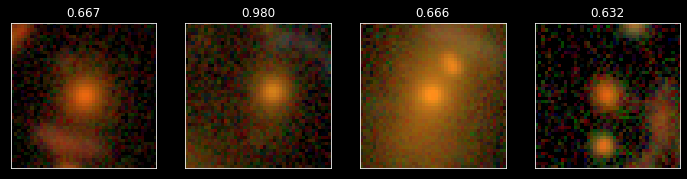

940889646
1544354650
1555408224


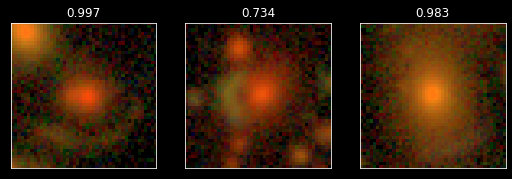

In [14]:
#Not identified with E < 6
print('Not identified with E < 6 \n')
for i in range(1, len(categories)):
    print(categories[i])
    if(len(images[i]) == 0): 
        print(' ')
        continue
    ind = all_data[i][all_data[i]['einstein_radius'] <= 6 ].index
    make_plot_all(images[i][ind], all_data[i].loc[ind])
    print(' ')

Identified with E < 6 

Positives
1150981093
1254690304
1380490997
1457701647


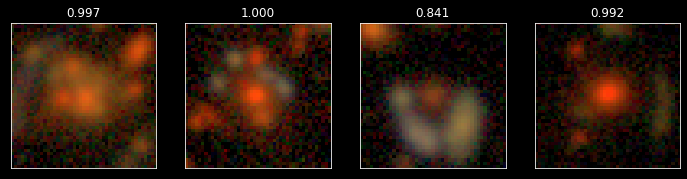

906297047
1065068829
1397786541
1237074304


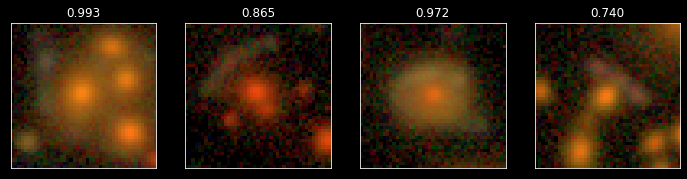

1177118232
1087586642
1194748640
1605209704


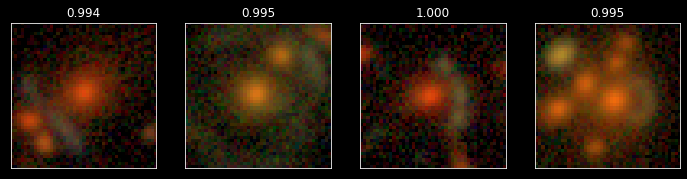

1215585225
1370519642
1543203779
1193586965


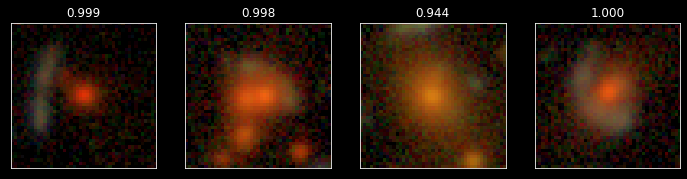

1010940448
1027961497
1471530329
1340791460


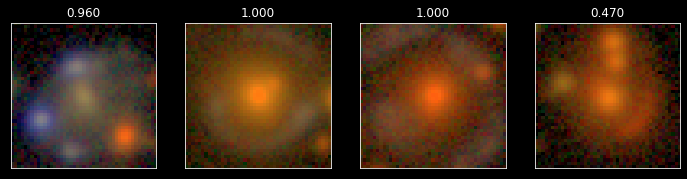

1282283042
1320090903
1095073803
996824828


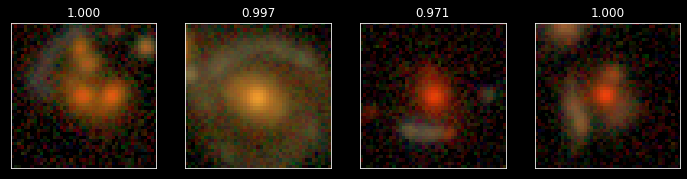

919882930
942145369
1380201297
1309246601


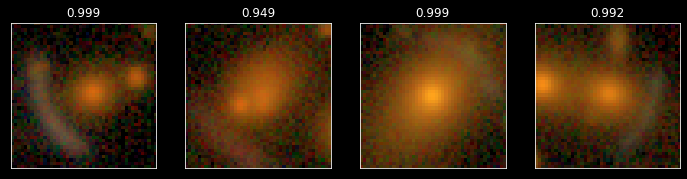

1253518858
1344635131
1132438466
1139453426


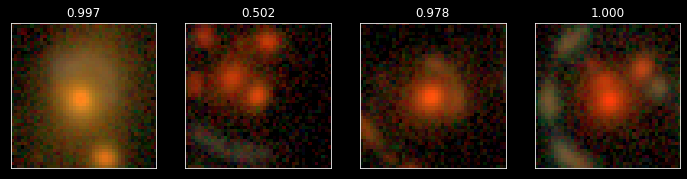

1235391858
1262885787
1136960821
958711616


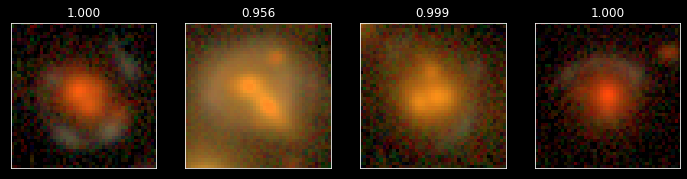

1237527717
1301081250
1406154832
1008494220


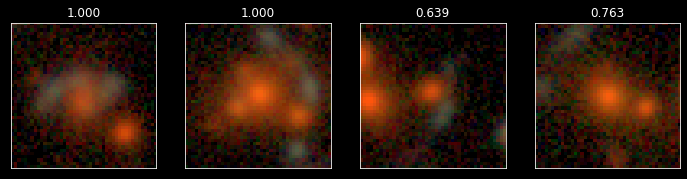

1560467285
1466200592
1424382704
1076469675


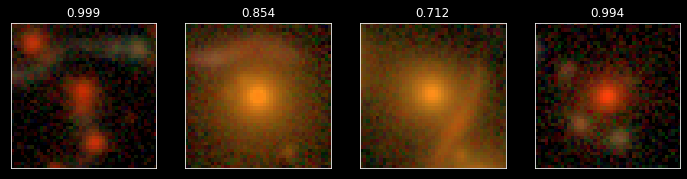

1618265499
1065852196
1005730815
1129249726


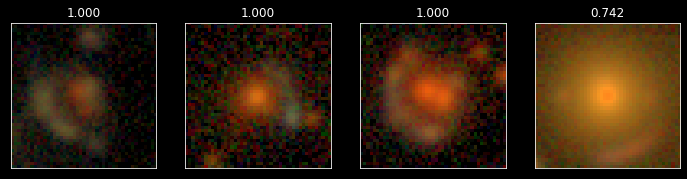

960634096
1188402103
1042572859
1429256248


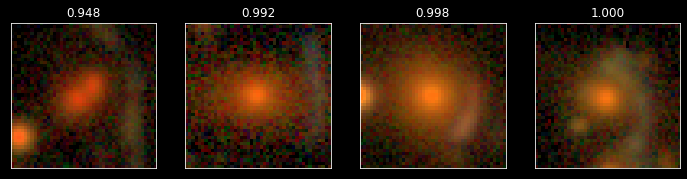

1431464188
1341473830
1196484135
1460366855


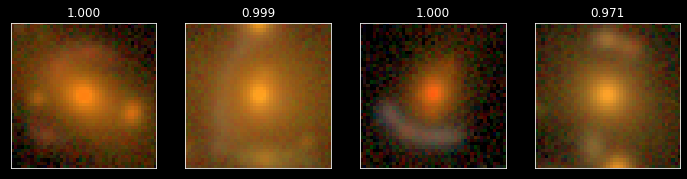

1613622977
1132666004
1075990880
1243683190


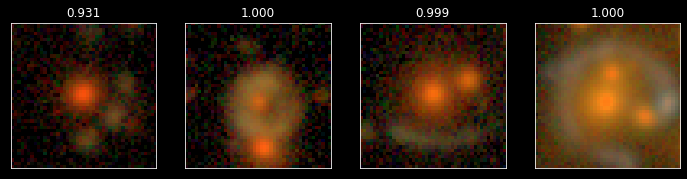

1120481923
1179738251
1492389862
1095012420


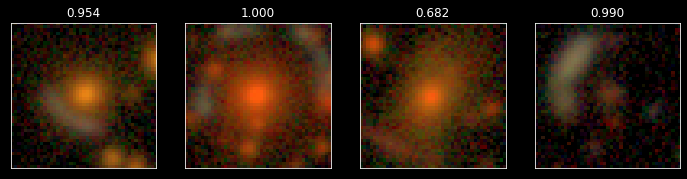

1410370257
1226283999
1425127607
1436738189


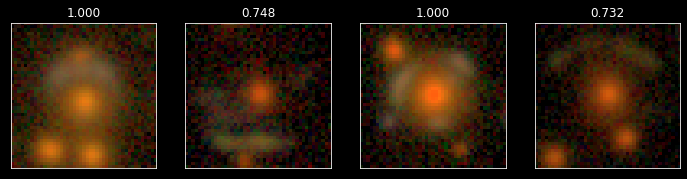

1079483534
945275549
1163516688
1100499372


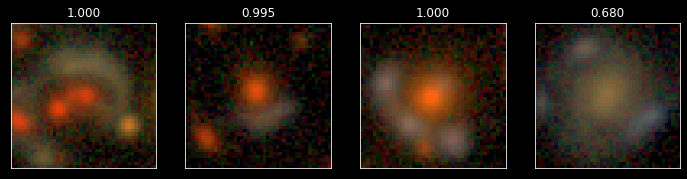

1175885227
1281613121
1033271849
1541861374


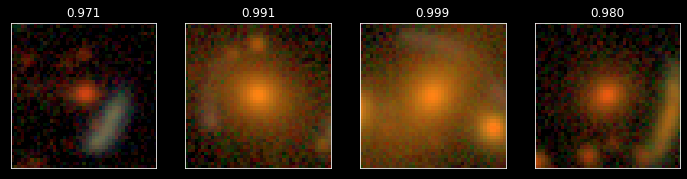

948472502
1438681779
1098825401
1015396778


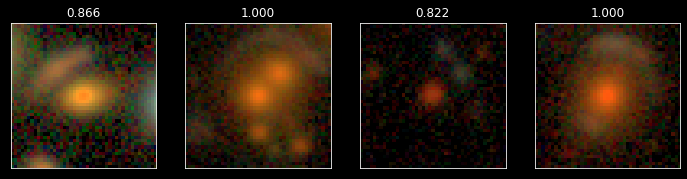

1561967167
1234418937
943336674
1248376226


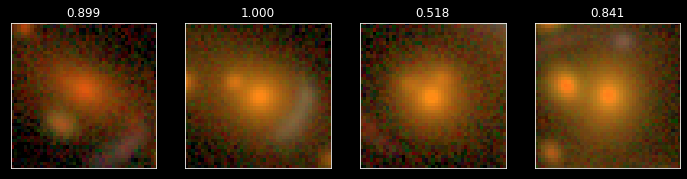

1186271916
1315897713
1535218994
1224505431


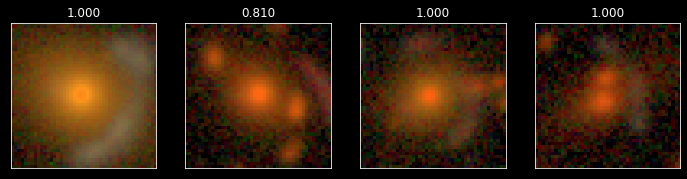

1014987031
1334070236
918844670


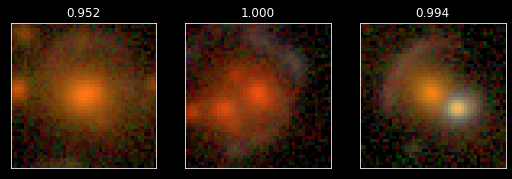

In [15]:
#Identified with E < 6
print('Identified with E < 6 \n')
print(categories[0])
ind = all_data[0][all_data[0]['einstein_radius'] <= 6 ].index
make_plot_all(images[0][ind], all_data[0].iloc[ind])

Not identified with E > 6 

Rings
1123546242


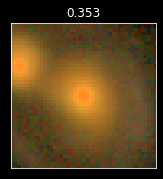

 
Smooth
 
Companion
 
SDSS
 
DES_spirals
1302913411


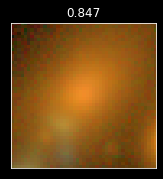

 
Crowded
1090651028
1585989929


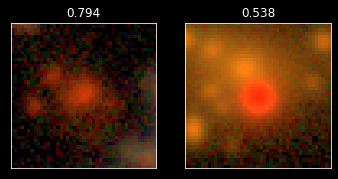

 
Errors
 
Most_negatives
1097449211
1604160427
1104152493
893678703


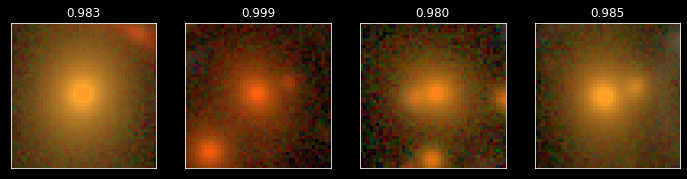

1041564142
1075010553
1432368460
1444189303


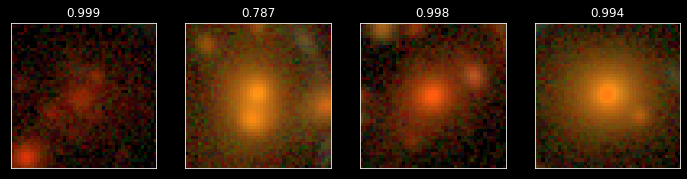

1445405684
1389753930
1372004130
1116860474


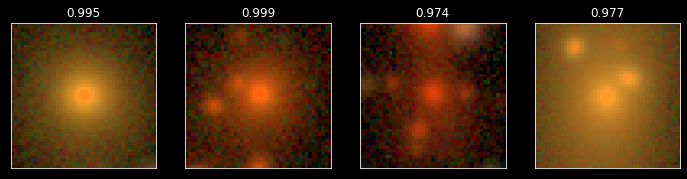

1096106638
1559105198
981335505
985651579


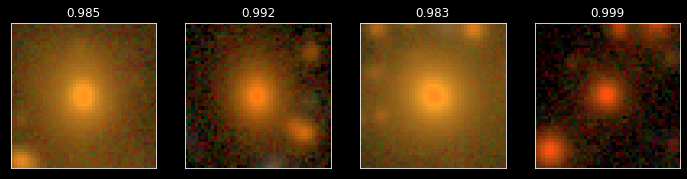

1096356557
1130037119
1539815370
1269458842


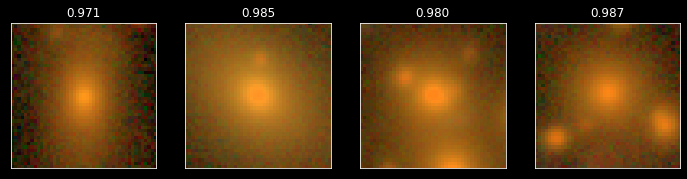

1075825038
1337694534
1253220108
1505761179


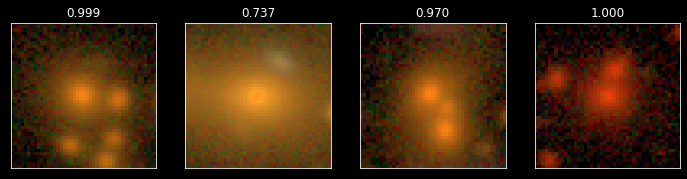

1022753178
912239998
1006398298
1080468439


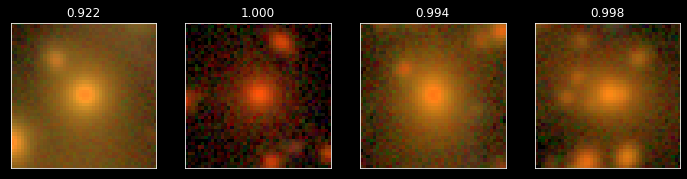

1033333108
1598223655
1320102858
1098063467


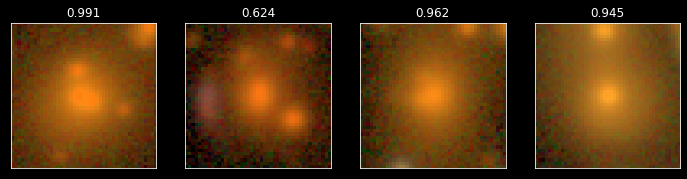

1620789333
874430227
1019075491
1365603963


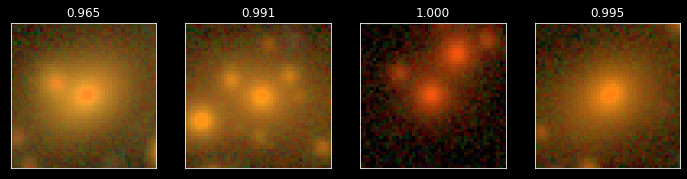

1369627471
1553993296
1478719341
1227352718


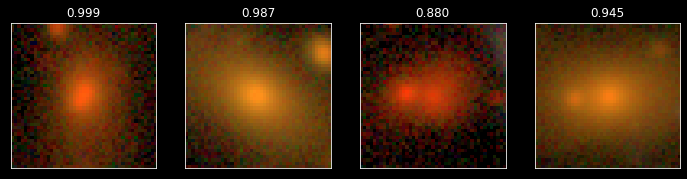

1518678765
873960975
1579393120
968514872


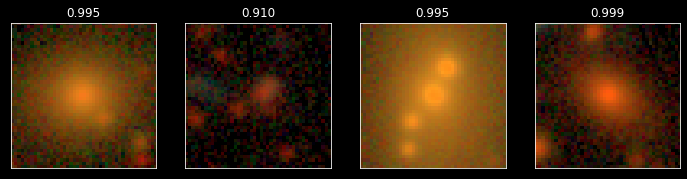

1497065303
1405862851
1211759750
972522805


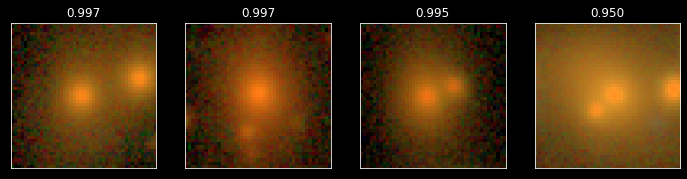

1448395045
1069554405
1135449475
1196267668


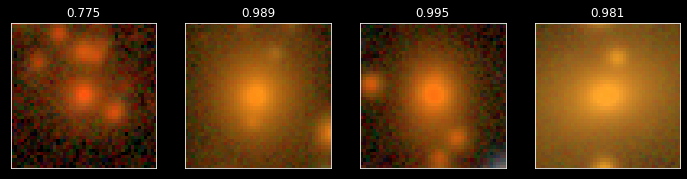

1312605504
1027060361
935500908
1344840821


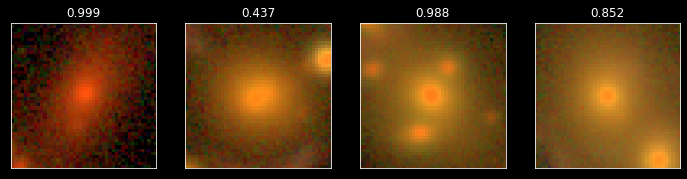

1329591757
1267131914
1018373612
1525378628


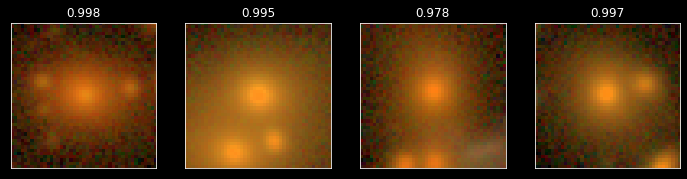

1311519346
1581430084
1262815086
934650347


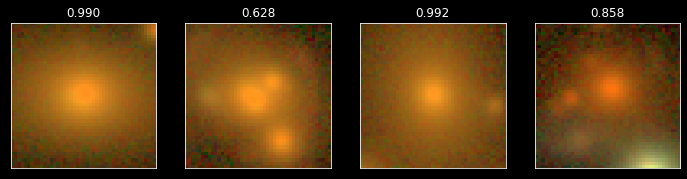

1311859703
1011335771
877696474
1144014836


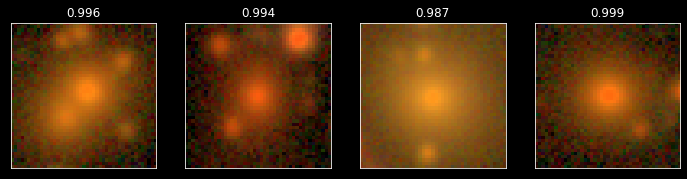

1021262800
1432853769
929464065
1205235466


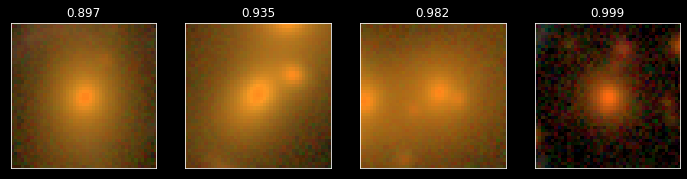

1022749274
1005190830
1339237461
1051146741


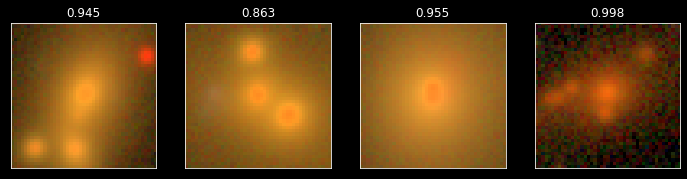

977331342
1096108699
1574006205
1039192988


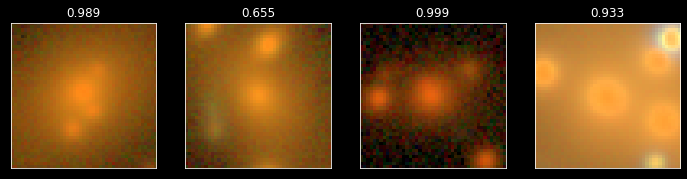

1532721542
1522920500
1100056641
1591618397


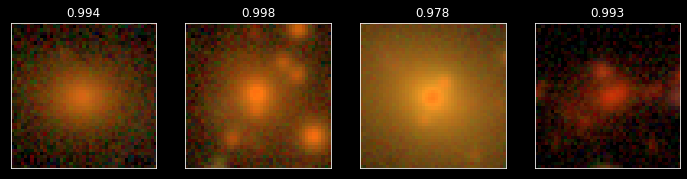

1404219210
1092532196
1276467865
1500313463


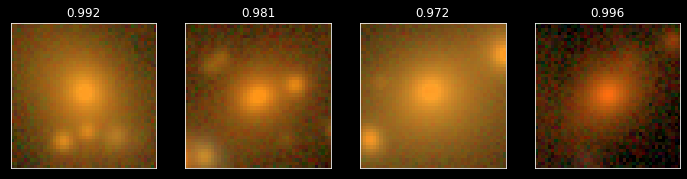

1512302706
1600288437
1310351225
875861728


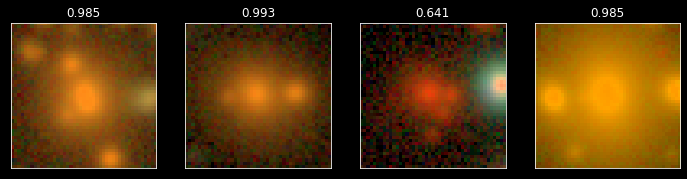

1131903141
992157466
894391144
1243894857


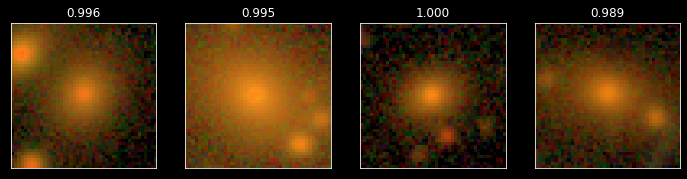

1417005344
1204581428
1333189566
1326662771


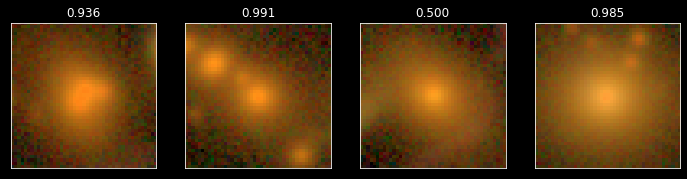

1182667355
926990988
1286324573
890123132


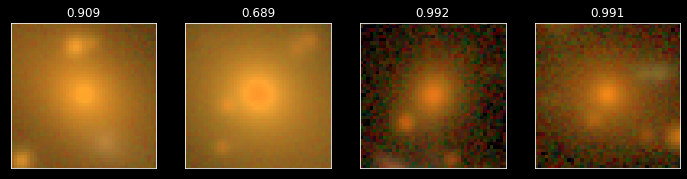

880775998
1413959827
1432395652


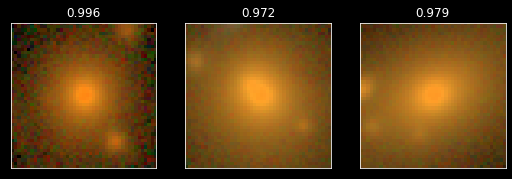

In [16]:
#Not identified with E > 6
print('Not identified with E > 6 \n')
for i in range(1, len(categories)):
    print(categories[i])
    if(len(images[i]) == 0): 
        print(' ')
        continue
    ind = all_data[i][all_data[i]['einstein_radius'] > 6 ].index
    make_plot_all(images[i][ind], all_data[i].loc[ind])
    print(' ')

Identified with E > 6 

Positives
1015716039
1461199109
1540902420
1048920254


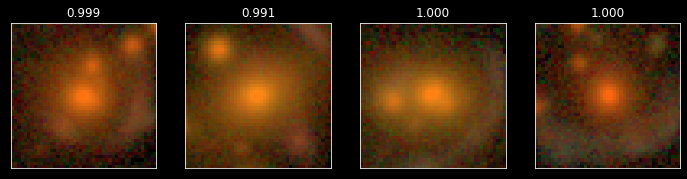

912635250
1249049816
1395103367
1396458125


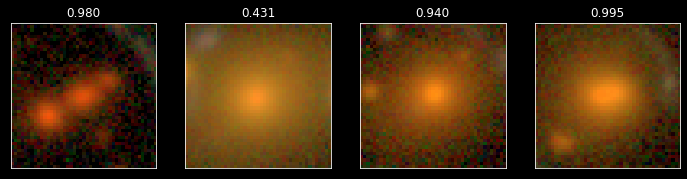

In [17]:
#Identified with E > 6
print('Identified with E > 6 \n')
print(categories[0])
ind = all_data[0][all_data[0]['einstein_radius'] > 6 ].index
make_plot_all(images[0][ind], all_data[0].iloc[ind])

In [18]:
names = ['Prob', 'einstein_radius', 'DNF_ZMEAN_SOF', 'rank', 'FLUX_RADIUS_G', 'KRON_RADIUS', 'GAP_FLUX_G',
         'MAG_AUTO_G', 'MAG_APER_4_G', 'MAG_APER_8_G', 'num_sources', 'num_lenses', 
         'einstein_radius_err']
print(len(names))
right_data = right_data[right_data['MAG_AUTO_G'] < 50]
wrong_data = wrong_data[wrong_data['MAG_AUTO_G'] < 50]

13


In [19]:
def make_histo(name):
    plt.figure(figsize=(16,5)) 

    plt.subplot(1,2,1)
    plt.title('All distribution: ' + str(name))
    data_all = np.concatenate((right_data[name], wrong_data[name]))
    plt.hist(data_all, density = True, bins = 'auto', edgecolor = 'black')
    
    
    plt.subplot(1,2,2)
    plt.title(name)
    plt.hist(right_data[name], density = True, bins = 'auto', color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
    plt.hist(wrong_data[name], density = True, bins = 'auto', color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
    plt.legend()
    
    plt.show()
        

def make_all_histos():
    for name in names:
        make_histo(name)

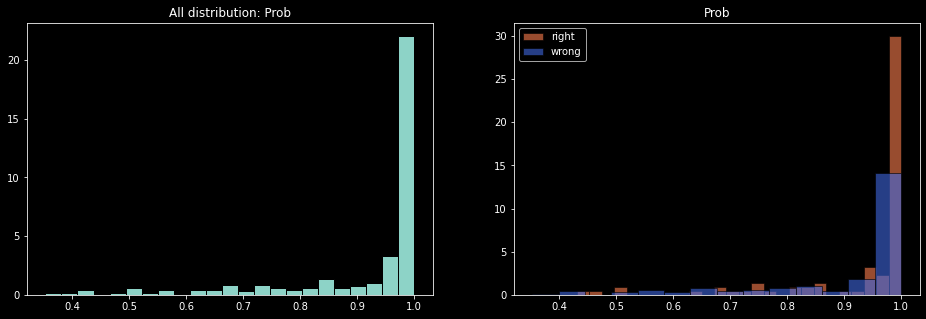

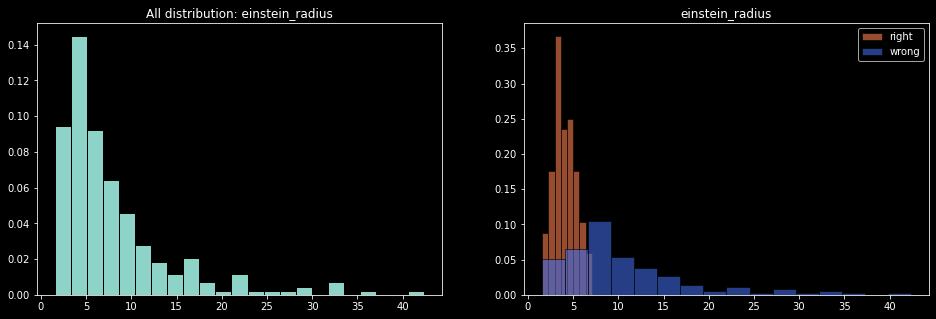

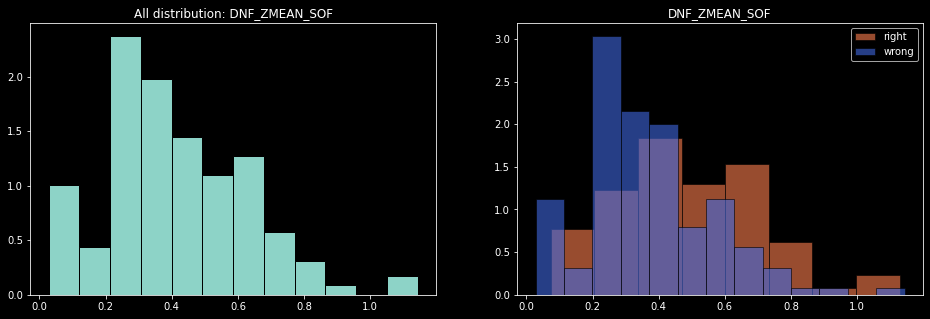

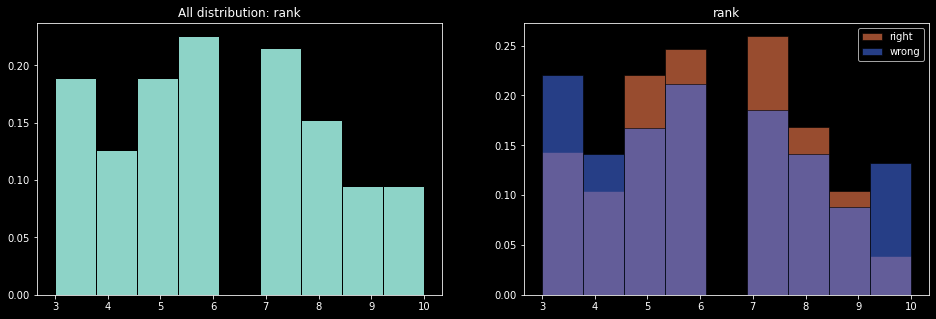

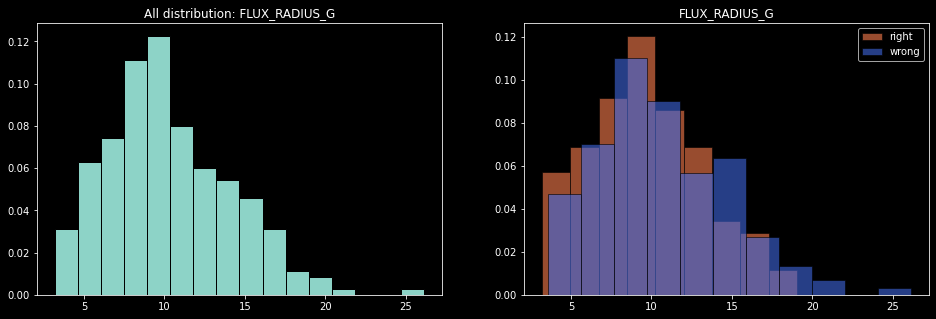

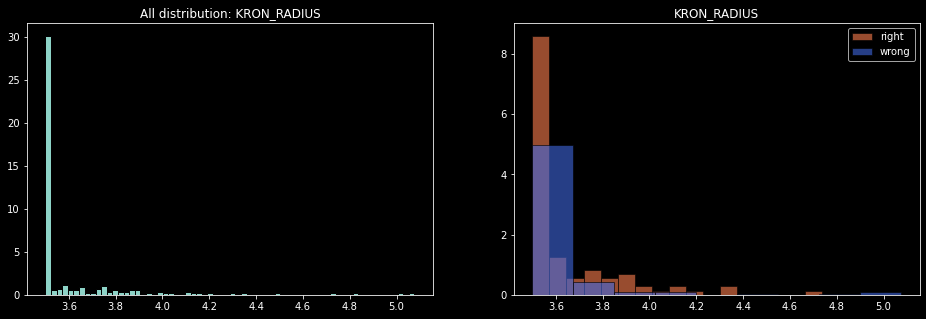

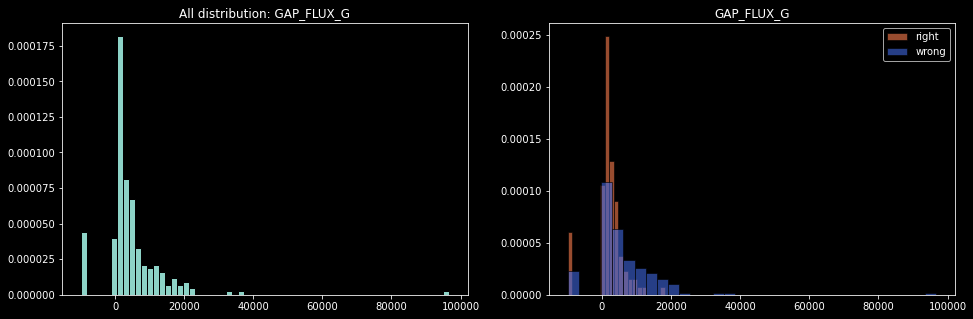

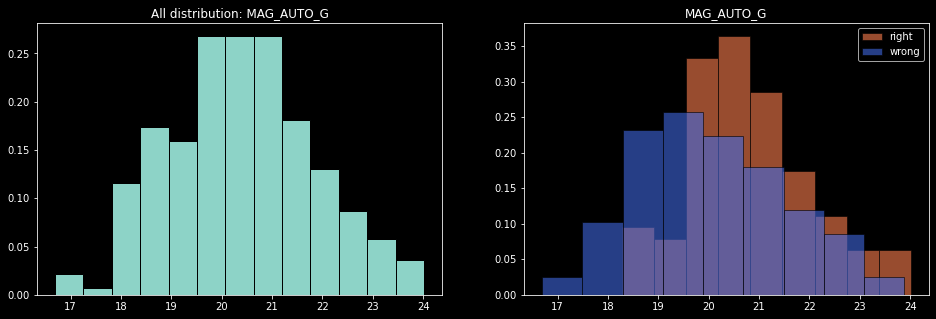

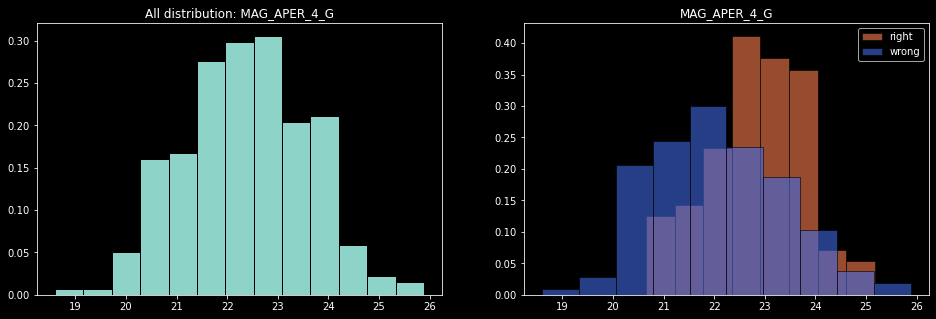

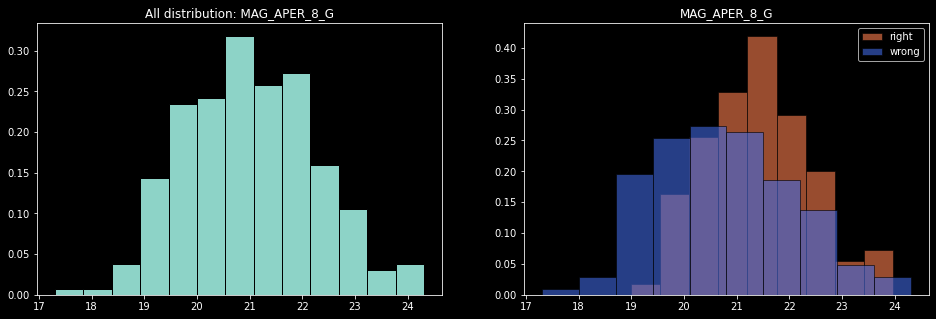

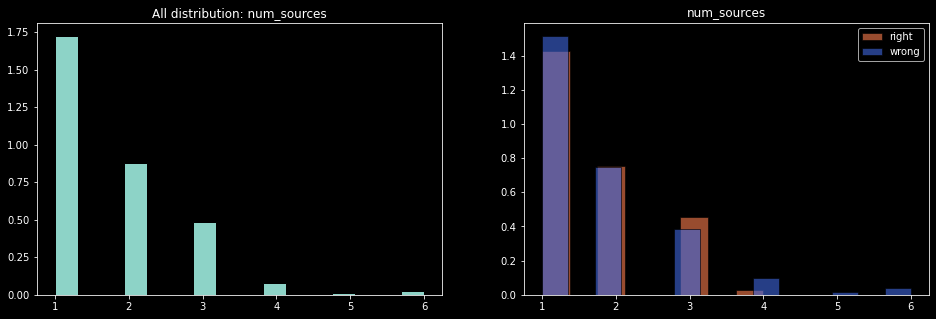

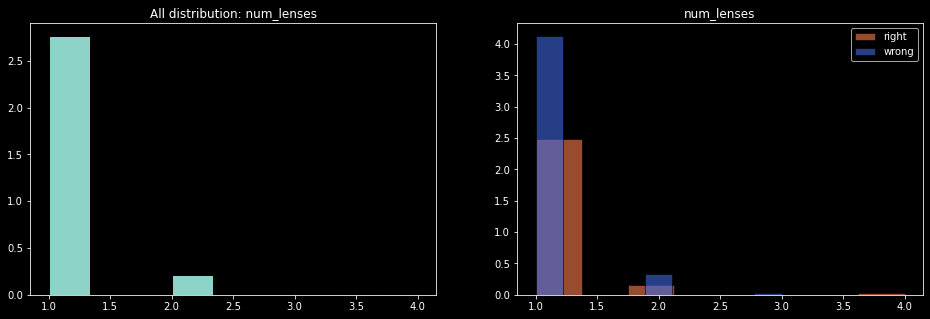

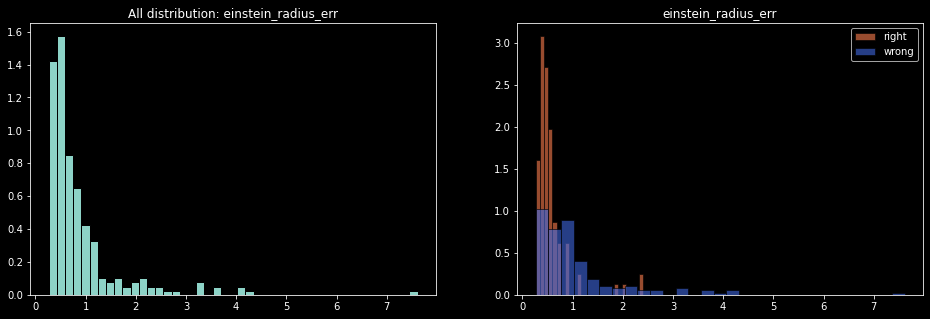

In [20]:
make_all_histos()

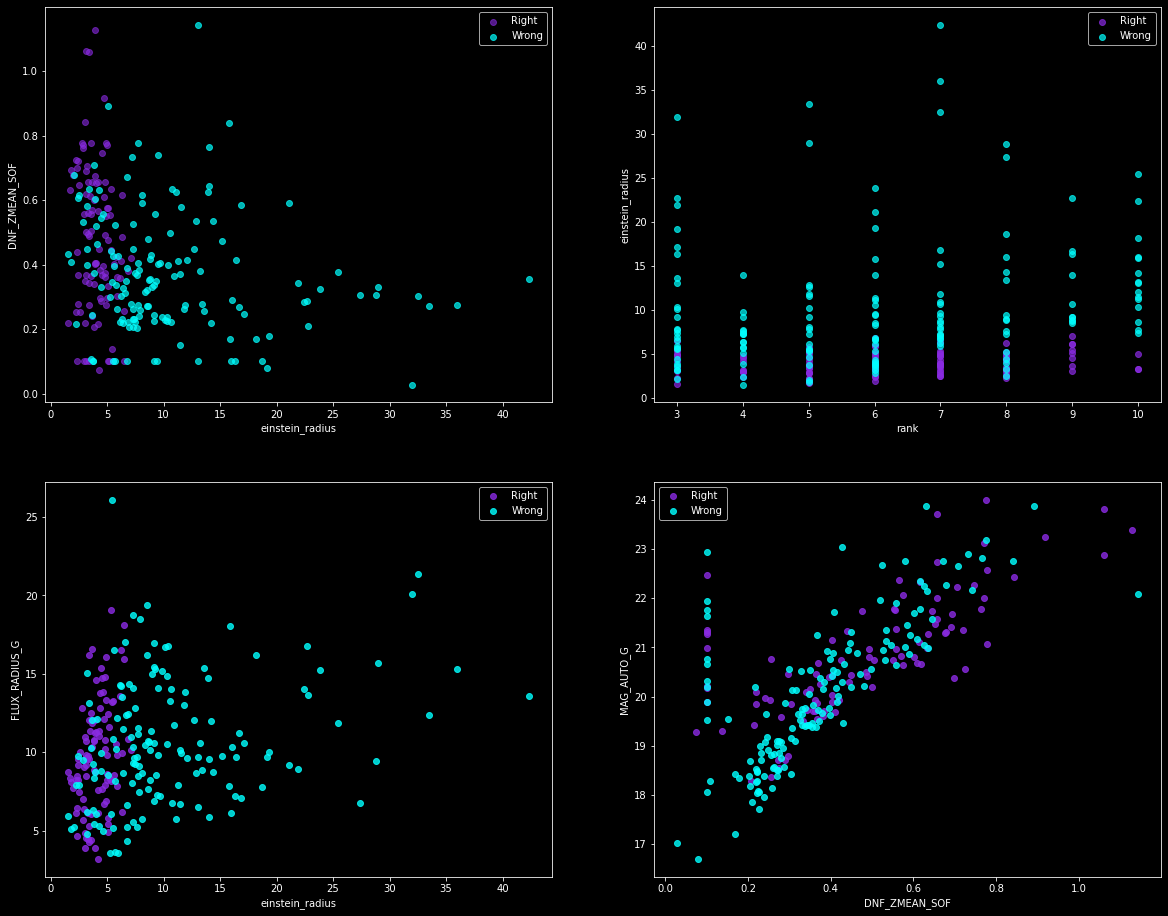

In [21]:
plt.figure(figsize=(20,16)) 

plt.subplot(2,2,1)
plt.xlabel(names[1])
plt.ylabel(names[2])
plt.scatter(right_data[names[1]], right_data[names[2]], color = 'blueviolet', alpha = 0.6, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[2]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel(names[3])
plt.ylabel(names[1])
plt.scatter(right_data[names[3]], right_data[names[1]], color = 'blueviolet', alpha = 0.7, label ='Right')
plt.scatter(wrong_data[names[3]], wrong_data[names[1]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel(names[1])
plt.ylabel(names[4])
plt.scatter(right_data[names[1]], right_data[names[4]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[4]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(2,2,4)
plt.xlabel(names[2])
plt.ylabel(names[7])
plt.scatter(right_data[names[2]], right_data[names[7]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[2]], wrong_data[names[7]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 
    
plt.show()

In [22]:
print(len(wrong_data)+len(right_data))

wrong_smaller = wrong_data[wrong_data['einstein_radius'] <= 6]
wrong_larger = wrong_data[wrong_data['einstein_radius'] > 6]
right_smaller = right_data[right_data['einstein_radius'] <= 6]
right_larger = right_data[right_data['einstein_radius'] > 6]

print(len(wrong_data), len(wrong_smaller), len(wrong_larger))
print(len(right_data), len(right_smaller), len(right_larger))

245
146 36 110
99 91 8


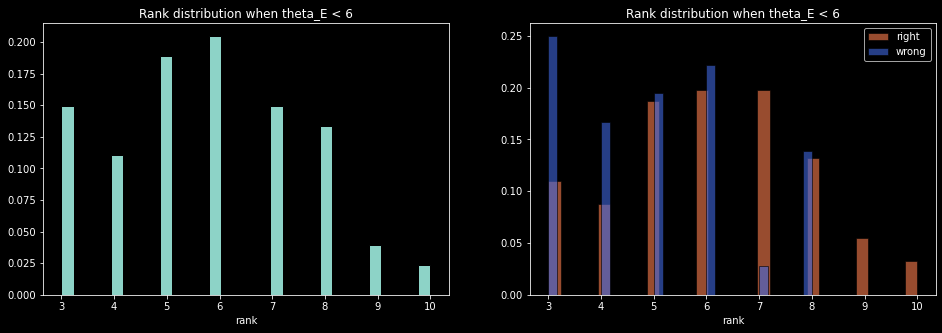

In [23]:
i=3

plt.figure(figsize=(16,5)) 

plt.subplot(1,2,1)
plt.title('Rank distribution when theta_E < 6')
plt.xlabel(names[i])
data_all = np.concatenate((right_smaller[names[i]], wrong_smaller[names[i]]))
weights = np.ones_like(data_all) / len(data_all)
plt.hist(data_all, 30, weights = weights, edgecolor = 'black')

plt.subplot(1,2,2)
plt.title('Rank distribution when theta_E < 6')
plt.xlabel(names[i])
weights = np.ones_like(right_smaller[names[i]]) / len(right_smaller[names[i]])
plt.hist(right_smaller[names[i]], 30, weights = weights, color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
weights = np.ones_like(wrong_smaller[names[i]]) / len(wrong_smaller[names[i]])
plt.hist(wrong_smaller[names[i]], 30, weights = weights, color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
plt.legend()  

plt.show()